In [20]:
#import 相關函式
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU, Conv2D, Flatten, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import RMSprop
from keras.backend.tensorflow_backend import set_session 
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
from matplotlib.pyplot import imshow
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
%matplotlib inline
#設定CPU使用量
config = tf.ConfigProto() 
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

In [21]:
#Loss 紀錄函式 提供繪製 acc-loss 圖
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

In [22]:
# 抓 mnist 資料,資料轉換對應的維度
(x_train, y_train), (x_test_org, y_test_org) = mnist.load_data()

print('shape of train data   [', x_train.shape[0], x_train.shape[1], x_train.shape[2],"]")
print('shape of test  data   [', x_test_org.shape[0], x_test_org.shape[1], x_test_org.shape[2],"]")
x_train=x_train.reshape(60000,28,28,1).astype('float32')
x_test=x_test_org.reshape(10000,28,28,1).astype('float32')  
x_train /= 255
x_test /= 255
print('reshape of train data [', x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3],"]")
print('reshape of test  data [', x_test.shape[0], x_test.shape[1], x_test.shape[2], x_test.shape[3], "]")
y_train=np_utils.to_categorical(y_train)
y_test=np_utils.to_categorical(y_test_org)
print()
print("To Categorical [", y_test_org[0], "] => ", y_test[0])

history = LossHistory()

shape of train data   [ 60000 28 28 ]
shape of test  data   [ 10000 28 28 ]
reshape of train data [ 60000 28 28 1 ]
reshape of test  data [ 10000 28 28 1 ]

To Categorical [ 7 ] =>  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [23]:
# CNN模型建置, 兩個CNN模型切換比較
switch = 0     
if switch == 1:
    model = Sequential()
    model.add(Conv2D(5, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(196, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()

else:
    model = Sequential()  
    # Create CN layer 1  
    model.add(Conv2D(filters=16,  
                     kernel_size=(5,5),  
                     padding='same',  
                     input_shape=(28,28,1),  
                     activation='relu'))  
    # Create Max-Pool 1  
    model.add(MaxPooling2D(pool_size=(2,2)))  

    # Create CN layer 2  
    model.add(Conv2D(filters=36,  
                     kernel_size=(5,5),  
                     padding='same',  
                     input_shape=(28,28,1),  
                     activation='relu'))  

    # Create Max-Pool 2  
    model.add(MaxPooling2D(pool_size=(2,2)))  

    # Add Dropout layer  
    model.add(Dropout(0.25))  
    model.add(Flatten()) 
    model.add(Dense(128, activation='relu'))  
    model.add(Dropout(0.5))  
    model.add(Dense(10, activation='softmax'))  
    model.summary()  

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 5)         130       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 5)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 720)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 196)               141316    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1970      
Total params: 143,416
Trainable params: 143,416
Non-trainable params: 0
_________________________________________________________________


In [24]:
# 開始訓練
train_history = model.fit(x_train, y_train,
            batch_size=128,
            epochs=10,
            verbose=1,
            validation_data=(x_test, y_test),
            callbacks=[history])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 100us/step - loss: 0.2690 - acc: 0.9193 - val_loss: 0.1106 - val_acc: 0.9664
Epoch 2/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.0969 - acc: 0.9711 - val_loss: 0.0741 - val_acc: 0.9759
Epoch 3/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.0648 - acc: 0.9802 - val_loss: 0.0523 - val_acc: 0.9827
Epoch 4/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.0490 - acc: 0.9850 - val_loss: 0.0534 - val_acc: 0.9826
Epoch 5/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.0388 - acc: 0.9879 - val_loss: 0.0403 - val_acc: 0.9858
Epoch 6/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.0304 - acc: 0.9907 - val_loss: 0.0536 - val_acc: 0.9819
Epoch 7/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.0255 - acc: 0.9922 - val_loss: 0.0466 - val_ac

10000/10000 [==============================] - 1s 63us/step
[Info] Accuracy of testing data = 98.7%

Test score: 0.04242846240499785
Test accuracy: 0.9872


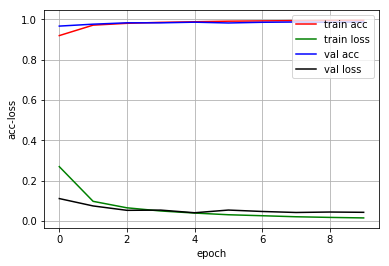

In [26]:
# 模型评估
score = model.evaluate(x_test, y_test, verbose=1)
print("[Info] Accuracy of testing data = {:2.1f}%".format(score[1]*100.0))  
print()
print('Test score:', score[0])
print('Test accuracy:', score[1])

# 繪製 acc-loss 曲线
history.loss_plot('epoch')

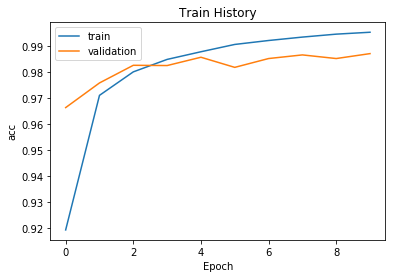

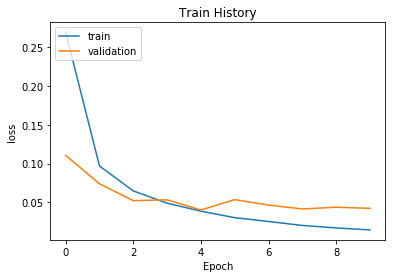

In [27]:
# 個別繪製 acc and loss 曲线
from utils import *  
if isDisplayAvl():  
    show_train_history(train_history, 'acc', 'val_acc')  
    show_train_history(train_history, 'loss', 'val_loss')  

[5 9 8 7 2 3 0 4 4 2]



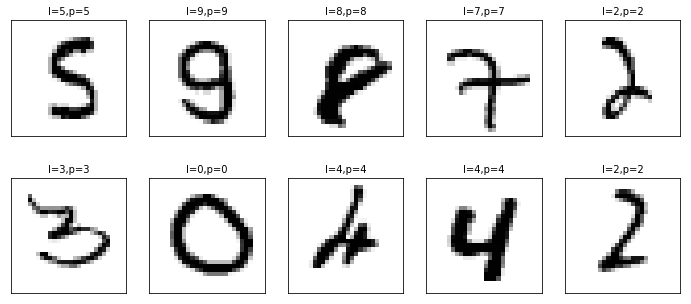

[Info] Display Confusion Matrix:
predict    0     1     2     3    4    5    6     7    8    9
label                                                        
0        975     0     1     0    1    0    0     0    2    1
1          0  1131     1     2    0    0    0     0    1    0
2          1     0  1015     6    2    0    0     7    1    0
3          0     0     1  1005    0    1    0     0    3    0
4          0     0     1     0  977    0    0     0    2    2
5          1     0     0    13    0  874    1     0    3    0
6          5     2     0     1    2    4  942     0    2    0
7          0     1     8     1    1    0    0  1011    3    3
8          1     0     3     4    0    0    0     1  963    2
9          1     2     0     5   10    1    0     8    3  979



In [28]:
# 模型评估 數據比對
prediction = model.predict_classes(x_test)  # Making prediction and save result to prediction  
print("%s\n" % (prediction[240:250]))  
if isDisplayAvl():  
    plot_images_labels_predict(x_test_org, y_test_org, prediction, idx=240) 
    
# 模型评估 數據分布統計  
import pandas as pd  
print("[Info] Display Confusion Matrix:")  
print("%s\n" % pd.crosstab(y_test_org, prediction, rownames=['label'], colnames=['predict']))  